## LeNet-5
📄 Gradient-based learning applied to document recognition. [Link](https://ieeexplore.ieee.org/document/726791)

LeNet เป็นสถาปัตยกรรม Convolutional Neural Network (CNN) ที่ถูกเสนอโดย Yann LeCun ในปี 1998 เพื่อแก้ปัญหาการจำแนกตัวเลขจาก MNIST dataset (ภาพตัวเลขเขียนด้วยมือ 0–9) ถือว่าเป็น CNN รุ่นบุกเบิกที่ปูทางให้ deep learning ในด้าน computer vision ที่เราใช้กันทุกวันนี้

### โครงสร้างหลักของ LeNet-5

#### โมเดล LeNet-5 ที่ใช้กันบ่อย ๆ ประกอบด้วย 7 เลเยอร์ (ไม่นับ input layer)

1. Input Layer
- ขนาด 32×32 พิกเซล (MNIST จริง ๆ มี 28×28 แต่ padding ขยายเป็น 32×32)
2. C1: Convolution Layer

- ฟิลเตอร์: 6 ตัว

- Kernel size: 5×5

- Output: 28×28×6

3. S2: Subsampling (Average Pooling)

- ขนาด 2×2

- Output: 14×14×6

4. C3: Convolution Layer

- ฟิลเตอร์: 16 ตัว (เชื่อมกับ subset ของ feature maps จาก S2)

- Kernel size: 5×5

- Output: 10×10×16

5. S4: Subsampling (Average Pooling)

- ขนาด 2×2

- Output: 5×5×16

6. C5: Convolution Layer (Fully Connected)

- ฟิลเตอร์: 120 ตัว

- Kernel size: 5×5 (ครอบทั้ง feature map)

- Output: 1×1×120

7. F6: Fully Connected Layer

- จำนวน neuron: 84

- Output Layer

- ใช้ Softmax (หรือ RBF เดิม ๆ) เพื่อจำแนกตัวเลข 0–9

### Install Libraries
- torch
- - PyTorch หลัก ใช้สร้างโมเดล Deep Learning, ทำคำนวณแบบ tensor (คล้าย NumPy แต่ optimized บน GPU), training neural network

- torchvision
- - เป็น extension สำหรับงาน Computer Vision เช่น โหลด datasets (MNIST, CIFAR, ImageNet), มี transforms (resize, normalize) และโมดูลโมเดลสำเร็จรูป (ResNet, VGG ฯลฯ)

- torchaudio
- - extension สำหรับงาน เสียง / audio processing เช่น โหลดไฟล์เสียง, แปลง spectrogram, และโมดูลโมเดลสำเร็จรูปด้านเสียง
 
- torchmetrics 
- - เอาไว้ใช้คำนวณ metrics สำหรับประเมินโมเดล เช่น Accuracy, Precision, Recall, F1-score โดยออกแบบมาให้ใช้งานง่ายและทำงานร่วมกับ PyTorch Lightning หรือ training loop ปกติ
  
- matplotlib
- - library สำหรับ การ plot กราฟและ visualization เช่น แสดงผลการ training loss, accuracy per epoch, ดูรูปภาพใน dataset ฯลฯ

### Set Up Environments

In [3]:
import os, random, math, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchmetrics.classification import MulticlassAccuracy, MulticlassConfusionMatrix
import numpy as np
from pathlib import Path

# fix random seed for reproducibility
SEED = 42

# Set random seeds for reproducibility
random.seed(SEED) # Python random module
np.random.seed(SEED) # numpy
torch.manual_seed(SEED) # torch
torch.cuda.manual_seed_all(SEED) # torch cuda

# For reproducibility when using CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps") # for Apple Silicon 
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda") # for NVIDIA GPU
else:
    DEVICE = torch.device("cpu") # for CPU

print("Using device:", DEVICE)

Using device: mps


### Transforms & Datasets
- Download / Load Datasets (with transforms)
- Clean Datasets
- Preprocess (Split train/val)
- Display / Inspect

In [4]:
# Mean and std for normalizing MNIST dataset
MNIST_MEAN, MNIST_STD = 0.1307, 0.3081

# Base transforms (no augmentation) for validation and test sets
base_transforms = transforms.Compose([
    transforms.Pad(2), # to make 28x28 images into 32x32
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)) # normalize with mean and std
])

# Augmentation for training set
train_transforms = transforms.Compose([
    transforms.Pad(2),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
])

#### Download / Load Datasets

In [5]:
DATA_DIR = "../data" # directory to store datasets

# Download / Load training and test datasets
train_ds_raw = datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=train_transforms)
test_ds  = datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=base_transforms)

# Check dataset sizes
len(train_ds_raw), len(test_ds)

100.0%
100.0%
100.0%
100.0%


(60000, 10000)

#### Clean Datasets

In [6]:
# A wrapper dataset to handle bad samples
class SafeDataset(torch.utils.data.Dataset):
    def __init__(self, ds):
        self.ds = ds
        self.bad_indices = []

    def __len__(self): return len(self.ds)

    def __getitem__(self, idx):
        try:
            return self.ds[idx]
        except Exception as e:
            self.bad_indices.append(idx)
            # If a bad sample is encountered, return a random good sample
            ridx = random.randint(0, len(self.ds)-1)
            return self.ds[ridx]

train_ds = SafeDataset(train_ds_raw)

#### Split train/val

In [7]:
# Split training dataset into train and validation set
VAL_RATIO = 0.1 # 10% for validation
val_size = int(len(train_ds) * VAL_RATIO) # validation set size
train_size = len(train_ds) - val_size # training set size

# Ensure the split is reproducible
train_ds, val_ds = random_split(train_ds, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
len(train_ds), len(val_ds)


(54000, 6000)

#### DataLoader

In [10]:

BATCH_SIZE = 128

# Note: num_workers > 0 may not work on Windows or MacOS
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

#### Display / Inspect

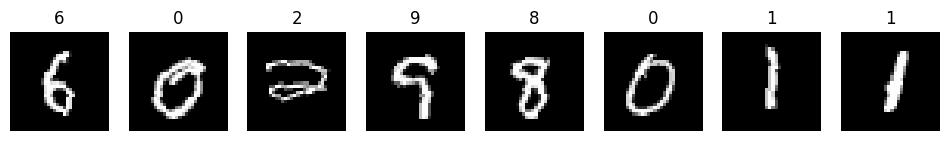

In [11]:
import matplotlib.pyplot as plt

# Function to display a batch of images
def show_batch(dl, n=8):
    imgs, labels = next(iter(dl)) # get a batch of images and labels
    imgs = imgs[:n].squeeze(1)  # (n, 32, 32) 
    labels = labels[:n] 
    plt.figure(figsize=(12,2))
    
    # Display images in a row
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(imgs[i].cpu().numpy(), cmap='gray')
        plt.title(int(labels[i]))
        plt.axis('off')
    plt.show()

show_batch(train_loader, n=8)

### LeNet-5 (Tanh activations + Average Pooling, conv map sizes)

In [13]:
# LeNet-5 model definition
# Original style: Tanh activations + Average Pooling, conv map sizes

class LeNet5(nn.Module):

    # Define the layers
    def __init__(self, num_classes=10):
        super().__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1) # 32->28
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2) # 28->14
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1) # 14->10
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2) # 10->5
        self.c5 = nn.Conv2d(16, 120, kernel_size=5, stride=1) # 5->1
        self.f6 = nn.Linear(120, 84) # 120->84
        self.out = nn.Linear(84, num_classes) # 84->num_classes

    # Define the forward pass
    def forward(self, x):
        x = torch.tanh(self.c1(x)) # (N,1,32,32) -> (N,6,28,28)
        x = self.s2(x) # (N,6,28,28) -> (N,6,14,14)
        x = torch.tanh(self.c3(x)) # (N,6,14,14) -> (N,16,10,10)
        x = self.s4(x) # (N,16,10,10) -> (N,16,5,5)
        x = torch.tanh(self.c5(x)) # (N,16,5,5) -> (N,120,1,1)
        x = x.view(x.size(0), -1) # flatten to (N,120)
        x = torch.tanh(self.f6(x)) # (N,120) -> (N,84)
        x = self.out(x) # (N,84) -> (N,num_classes)
        return x

In [14]:
# Instantiate the model and move to device.
model = LeNet5().to(DEVICE)
sum(p.numel() for p in model.parameters()), model

(61706,
 LeNet5(
   (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
   (s2): AvgPool2d(kernel_size=2, stride=2, padding=0)
   (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (s4): AvgPool2d(kernel_size=2, stride=2, padding=0)
   (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
   (f6): Linear(in_features=120, out_features=84, bias=True)
   (out): Linear(in_features=84, out_features=10, bias=True)
 ))

### Loss, Optimizer, Metrics

In [29]:
# Hyperparameters
LR = 1e-3 # learning rate
EPOCHS = 30 # number of epochs
WEIGHT_DECAY = 0.0 # weight decay (L2 regularization)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # combines nn.LogSoftmax() and nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY) # Adam optimizer

# Metrics
num_classes = 10 # number of classes in MNIST
acc_metric_val = MulticlassAccuracy(num_classes=num_classes).to(DEVICE) # accuracy metric for validation
acc_metric_test = MulticlassAccuracy(num_classes=num_classes).to(DEVICE) # accuracy metric for test

### Train / Validate Loop (with early stopping)

In [30]:
# Training function for one epoch

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x,y in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return running_loss/total, correct/total

In [31]:
# Evaluation function

def evaluate(model, loader, criterion, metric):
    model.eval()
    metric.reset()
    running_loss, total = 0.0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            running_loss += loss.item() * x.size(0)
            total += y.size(0)
            metric.update(logits, y)
    return running_loss/total, metric.compute().item()

In [32]:
# Training / Validation loop with early stopping

best_val_acc, best_state = 0.0, None
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion, acc_metric_val)
    if val_acc > best_val_acc:
        best_val_acc, best_state = val_acc, {k: v.cpu().clone() for k,v in model.state_dict().items()}

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {val_loss:.4f} acc {val_acc:.4f}")

/Users/morse/Documents/morse-workspaces/computer-vision-engineer/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train loss 0.0268 acc 0.9914 | val loss 0.0441 acc 0.9860
Epoch 02 | train loss 0.0279 acc 0.9913 | val loss 0.0447 acc 0.9857
Epoch 03 | train loss 0.0258 acc 0.9916 | val loss 0.0429 acc 0.9869
Epoch 04 | train loss 0.0271 acc 0.9914 | val loss 0.0403 acc 0.9890
Epoch 05 | train loss 0.0269 acc 0.9916 | val loss 0.0491 acc 0.9850
Epoch 06 | train loss 0.0270 acc 0.9907 | val loss 0.0431 acc 0.9878
Epoch 07 | train loss 0.0267 acc 0.9913 | val loss 0.0452 acc 0.9848
Epoch 08 | train loss 0.0237 acc 0.9920 | val loss 0.0436 acc 0.9861
Epoch 09 | train loss 0.0252 acc 0.9920 | val loss 0.0370 acc 0.9890
Epoch 10 | train loss 0.0234 acc 0.9926 | val loss 0.0389 acc 0.9879
Epoch 11 | train loss 0.0257 acc 0.9920 | val loss 0.0456 acc 0.9859
Epoch 12 | train loss 0.0249 acc 0.9914 | val loss 0.0422 acc 0.9858
Epoch 13 | train loss 0.0227 acc 0.9928 | val loss 0.0416 acc 0.9865
Epoch 14 | train loss 0.0237 acc 0.9922 | val loss 0.0392 acc 0.9885
Epoch 15 | train loss 0.0244 acc 0

In [33]:
# Load the best model state (early stopping)
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(DEVICE)

### Test & Evaluate (accuracy, confusion matrix, per-class report)

In [34]:
# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, acc_metric_test)
print(f"TEST | loss {test_loss:.4f} | acc {test_acc:.4f}")

TEST | loss 0.0197 | acc 0.9931


In [35]:
# Confusion Matrix
cm_metric = MulticlassConfusionMatrix(num_classes=num_classes).to(DEVICE)
model.eval()
cm_metric.reset()

# Compute confusion matrix
with torch.no_grad():
    for x,y in test_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        cm_metric.update(logits, y)
cm = cm_metric.compute().cpu().numpy()

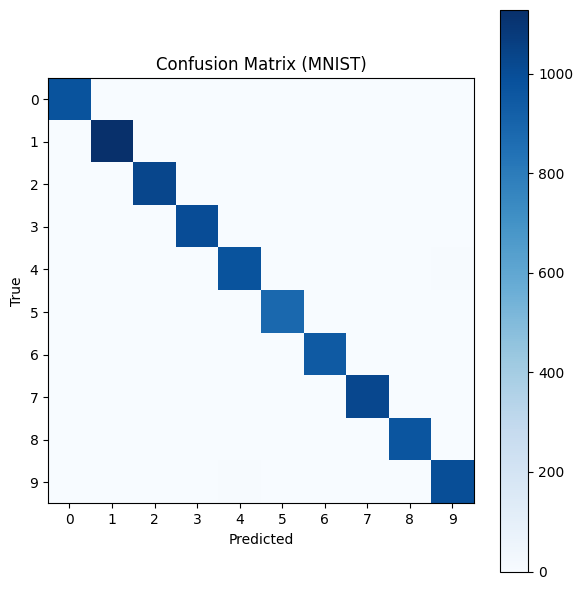

In [36]:
# Plot confusion matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix (MNIST)')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks); plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()

In [37]:
# Save the model checkpoint
Path("checkpoints").mkdir(exist_ok=True)
torch.save(model.state_dict(), "checkpoints/lenet5_mnist.pt")

In [38]:
# Load the model checkpoint
m2 = LeNet5().to(DEVICE)
m2.load_state_dict(torch.load("checkpoints/lenet5_mnist.pt", map_location=DEVICE))
m2.eval()

LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)

### Applied

In [39]:
from PIL import Image, ImageOps
import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os, glob

In [41]:
# Mean and std for normalizing MNIST dataset
MNIST_MEAN, MNIST_STD = 0.1307, 0.3081

# Version compatibility for Pillow
try:
    # Pillow 9/10 compatibility
    BILINEAR = Image.Resampling.BILINEAR
    LANCZOS = Image.Resampling.LANCZOS
except:
    # Older Pillow versions
    BILINEAR = Image.BILINEAR
    LANCZOS = Image.LANCZOS

#### Utilitie

In [ ]:
def _auto_invert(img_L: Image.Image) -> Image.Image:
    """Invert image if background is darker than foreground (based on mean pixel value)"""
    
    # average pixel value in [0..255]; high mean = white background
    mean_val = np.asarray(img_L).mean()
    return ImageOps.invert(img_L) if mean_val > 127 else img_L

def _tight_crop(img_L: Image.Image, thr=10):
    """Crop only the area with ink (values greater than thr after inversion)"""

    # Convert to numpy array
    arr = np.asarray(img_L)
    mask = arr > thr
    if not mask.any():
        return img_L  # if all pixels are below threshold, return original image
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()
    return img_L.crop((x0, y0, x1+1, y1+1))

#### Preprocessing Pipeline

In [ ]:
def preprocess_for_lenet(img_path: str) -> torch.Tensor:
    """
    Read any image 

    -> Grayscale 
    -> Auto Invert 
    -> Tight Crop 
    -> Resize with longest side=20 
    -> Paste on 28x28 canvas centered 
    -> Pad to 32x32 
    -> ToTensor + Normalize

    Return tensor shape (1, 1, 32, 32)
    """
    # open image, convert to grayscale, auto invert, tight crop
    img = Image.open(img_path).convert("L")
    img = _auto_invert(img)
    img = _tight_crop(img)

    # adjust size to have longest side = 20 pixels (keep aspect ratio)
    w, h = img.size

    # scale longest side to 20 pixels
    if w >= h:
        new_w, new_h = 20, max(1, int(round(20 * h / w)))
    else:
        new_h, new_w = 20, max(1, int(round(20 * w / h)))
    img = img.resize((new_w, new_h), resample=LANCZOS)

    # paste on 28x28 canvas centered
    canvas28 = Image.new("L", (28, 28), color=0)
    left = (28 - new_w) // 2
    top  = (28 - new_h) // 2
    canvas28.paste(img, (left, top))

    # pad to 32x32
    canvas32 = ImageOps.expand(canvas28, border=2, fill=0)

    # ToTensor + Normalize to match training
    tfm = T.Compose([
        T.ToTensor(), # (1, 32, 32), values in [0,1]
        T.Normalize((MNIST_MEAN,), (MNIST_STD,))
    ])
    x = tfm(canvas32).unsqueeze(0) # (1,1,32,32)
    return x

#### Predict Image

In [49]:
def predict_image(img_path: str, model, device=DEVICE, show=True, topk=3):
    x = preprocess_for_lenet(img_path).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = logits.softmax(dim=1).squeeze(0).cpu().numpy()
    pred = int(probs.argmax())
    
    # top-k
    idxs = probs.argsort()[-topk:][::-1]
    topk_list = [(int(i), float(probs[i])) for i in idxs]

    print(f"[{os.path.basename(img_path)}] Pred: {pred} | top-{topk}: {topk_list}")

    if show:
        # display original and preprocessed images
        fig = plt.figure(figsize=(6,3))
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(Image.open(img_path).convert("L"), cmap="gray")
        ax1.set_title("Original"); ax1.axis("off")

        # preprocessed image
        img = Image.open(img_path).convert("L")
        img = _auto_invert(img)
        img = _tight_crop(img)
        
        # adjust size to have longest side = 20 pixels (keep aspect ratio)
        w,h = img.size
        if w >= h:
            new_w, new_h = 20, max(1, int(round(20*h/w)))
        else:
            new_h, new_w = 20, max(1, int(round(20*w/h)))
        img = img.resize((new_w, new_h), resample=LANCZOS)
        canvas28 = Image.new("L", (28,28), color=0); canvas28.paste(img, ((28-new_w)//2, (28-new_h)//2))
        canvas32 = ImageOps.expand(canvas28, border=2, fill=0)

        ax2 = fig.add_subplot(1,2,2)
        ax2.imshow(np.asarray(canvas32), cmap="gray")
        ax2.set_title(f"Preprocessed → 32×32\nPred: {pred}"); ax2.axis("off")
        plt.tight_layout(); plt.show()

    return pred, topk_list

[my_num_1.png] Pred: 9 | top-5: [(9, 0.9861380457878113), (3, 0.012835435569286346), (8, 0.00042790966108441353), (5, 0.0003819671692326665), (4, 0.00010591921454761177)]


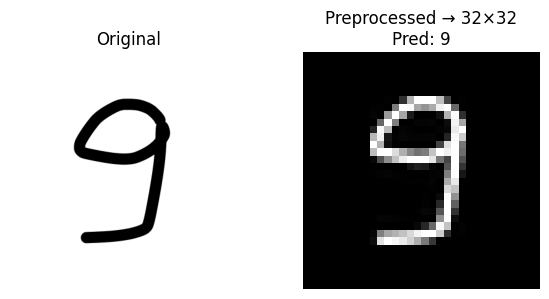

In [50]:
_ = predict_image("../images/my_num_1.png", m2, show=True, topk=5)